In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import lumenclass
import system

from scipy.integrate import solve_ivp
from scipy.integrate import odeint

import plot_graphs as plg

from matplotlib.ticker import FormatStrFormatter

In [2]:
def p_conversion(L1, L2, eps1, eps2, Ltot) :
    res1, res2 = np.zeros(len(L1)), np.zeros(len(L2))
    
    for i in range(len(L1)) :
        if L1[i] > 1e-3 :
            res1[i] = eps1*Ltot/L1[i]
        if L2[i] > 1e-3 :
            res2[i] = eps2*Ltot/L2[i]

    return res1, res2

def func_jLi(Li, Ni, mu_i, nu_i, eps_i) :
    res = np.zeros(len(Li))
    for i in range(len(Li)) :
        if Li[i] > 1e-3 and Ni[i] > 1e-6 :
            res[i] = mu_i*nu_i*(mu_i*Ni[i]/(Li[i]**2) - 1. - eps_i/Li[i])
    return res

def func_jNi(Li, Ni, mu_i, nu_i, ca) :
    res = np.zeros(len(Li))
    for i in range(len(Li)) :
        if Li[i] > 1e-3 and Ni[i] > 1e-6 :
            res[i] = 2*nu_i*Li[i]*( 1. + ca - mu_i*Ni[i]/(Li[i]**2))
    return res

In [9]:
e0, pi0, abs_gamma = 1e-2, 1e5, 2e-4

ca, ca_asymmetry = 0., 0.
ca_cl, ca_1, ca_2 = ca, ca+ca_asymmetry, ca-ca_asymmetry

ell0 = .44718

taus, tauv = 1., 1.
xis, xiv   = 10., 10.


L1, N1 = 1.487, 3.623
L2, N2 = 0.816, 1.092

Ltot = ell0+L1+L2
L1, L2, ell0, Ltot = L1/Ltot, L2/Ltot, ell0/Ltot, Ltot/Ltot

xc1 = - 0.5*ell0 - L1
xc2 = 0.5*ell0 + L2


gamma1, gammac1, theta1, epsilon1 = 1., 1., np.pi/3., 1e-3
gamma2, gammac2, theta2, epsilon2 = 1., 1., np.pi/3., 1e-3

lumen1 = lumenclass.lumen(center=xc1, init_length=L1, init_nb_ions=N1, tension=gamma1, contact_tension=gammac1, theta=theta1, epsilon=epsilon1)
lumen2 = lumenclass.lumen(center=xc2, init_length=L2, init_nb_ions=N2, tension=gamma2, contact_tension=gammac2, theta=theta2, epsilon=epsilon2)

init_ions = 1
if init_ions :
    lumen1.init_nb_ions = L1**2 / lumen1.mu#lumen1.__calc_osmoticequilibrium_nbions__()
    lumen2.init_nb_ions = L2**2 / lumen2.mu#lumen2.__calc_osmoticequilibrium_nbions__()
    lumen1.nb_ions = lumen1.init_nb_ions
    lumen2.nb_ions = lumen2.init_nb_ions

# Define the full chain
#print(lumen1.init_nb_ions, lumen2.init_nb_ions)
#print(lumen1.mu)

syst = system.system(lumen1, lumen2, ell=ell0, xis=xis, xiv=xiv, taus=taus, tauv=tauv, e0=e0, ca_cl=ca, ca_1=ca, ca_2=ca, pi0=pi0, abs_gamma=abs_gamma, sim_type='normal')

Y0 = [lumen1.init_length, lumen1.init_nb_ions, lumen2.init_length, lumen2.init_nb_ions]

#print 'L1 = ' + str(Y0[0])
#print 'N1 = ' + str(Y0[1])
#print 'L2 = ' + str(Y0[2])
#print 'N2 = ' + str(Y0[3])
#print 
#print 'ell0 = '+str(ell0)+' ; Ltot = ' + str(Ltot)

tmax = .1

nb_pts = 241
t = np.linspace(0, tmax, nb_pts)

parameters = {r'$\xi_s$' : xis, r'$\xi_v$' : xiv, r'$\tau_s$' : taus, r'$\tau_v$' : tauv, r'$c_a$' : ca}


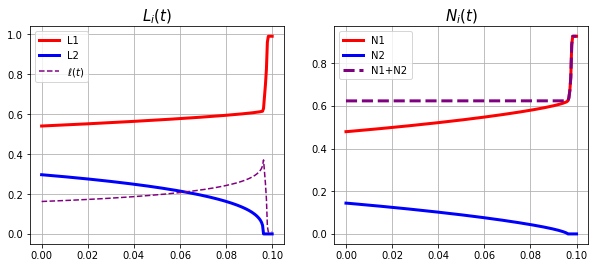

In [10]:
sol_ivp = solve_ivp(syst.__system__, t_span=[0., tmax], y0=Y0, t_eval=t, method='LSODA')
L1_ivp, N1_ivp, L2_ivp, N2_ivp = sol_ivp.y[0], sol_ivp.y[1], sol_ivp.y[2], sol_ivp.y[3]
ellt = Ltot - L1_ivp - L2_ivp

fig_ivp, ax_ivp = plt.subplots(1, 2, figsize=(10, 4))
#plt.suptitle('ivp integration', fontsize=15)
ax_ivp[0].plot(sol_ivp.t, L1_ivp, color='r', linewidth=3, label = 'L1')
ax_ivp[0].plot(sol_ivp.t, L2_ivp, color='b', linewidth=3, label = 'L2')
ax_ivp[0].plot(sol_ivp.t, ellt, color = 'purple', linestyle = '--', label = '$\ell(t)$')
ax_ivp[0].set_title('$L_i(t)$', fontsize=15)
ax_ivp[0].grid()
ax_ivp[0].legend()
ax_ivp[1].set_title('$N_i(t)$', fontsize=15)
ax_ivp[1].plot(sol_ivp.t, N1_ivp, color='r', linewidth=3, label = 'N1')
ax_ivp[1].plot(sol_ivp.t, N2_ivp, color='b', linewidth=3, label = 'N2')
ax_ivp[1].plot(sol_ivp.t, N1_ivp+N2_ivp, color='purple', linewidth=3, label = 'N1+N2', linestyle='--')
ax_ivp[1].grid()
ax_ivp[1].legend()
#ax_ivp[1].xaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.show()


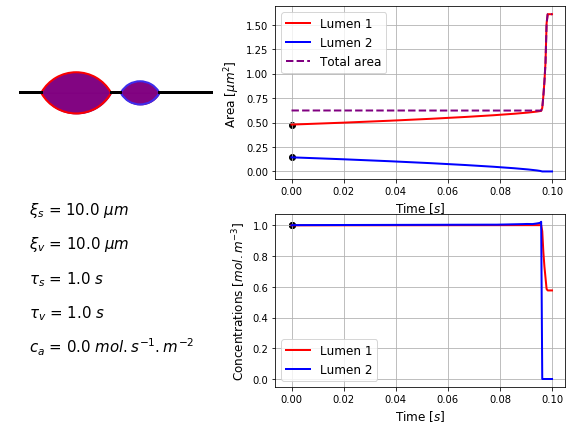

In [11]:
A1, A2 = L1_ivp**2 / lumen1.mu, L2_ivp**2 / lumen2.mu

tstep=0
save = 0
folder = '/Users/mathieuleverge/git/cavitation/2lumens/'
name = 'competition_6.png'
plg.print_step_nocleft(t, tstep=tstep, A1=A1, A2=A2, N1=N1_ivp, N2=N2_ivp, theta1=theta1, theta2=theta2, xc1=xc1, xc2=xc2, e0=e0, xt_min=-1.5, xt_max=1.5, params=parameters, x0=0.1, log=0, show=1, save=save, savename=folder+name)



In [6]:
A1, A2 = L1_ivp**2 / lumen1.mu, L2_ivp**2 / lumen2.mu


folder = '/Users/mathieuleverge/git/cavitation/2lumens/movie8/'
save = 0
show = 0

try :
    os.mkdir(folder)
except :
    pass


N = 1
print str(len(t)/N) + ' pictures to generate'
if save or show :
    for tstep in range(len(t)/N) :
        plg.print_step_nocleft(t, tstep=tstep*N, A1=A1, A2=A2, N1=N1_ivp, N2=N2_ivp, theta1=theta1, theta2=theta2, xc1=xc1, xc2=xc2, e0=e0, xt_min=-1.5, xt_max=1.5, params=parameters, x0=0.1, log=0, show=show, save=save, savename=folder+str(tstep).zfill(4)+'.png') 
        if tstep % 10 == 0 :
            print tstep


241 pictures to generate


In [7]:
def p_conversion(L1, L2, eps1, eps2, Ltot) :
    res1, res2 = np.zeros(len(L1)), np.zeros(len(L2))
    
    for i in range(len(L1)) :
        if L1[i] > 1e-3 :
            res1[i] = eps1*Ltot/L1[i]
        if L2[i] > 1e-3 :
            res2[i] = eps2*Ltot/L2[i]

    return res1, res2

def func_jLi(Li, Ni, mu_i, nu_i, eps_i) :
    res = np.zeros(len(Li))
    for i in range(len(Li)) :
        if Li[i] > 1e-3 and Ni[i] > 1e-6 :
            res[i] = mu_i*nu_i*(mu_i*Ni[i]/(Li[i]**2) - 1. - eps_i/Li[i])
    return res

def func_jNi(Li, Ni, mu_i, nu_i, ca) :
    res = np.zeros(len(Li))
    for i in range(len(Li)) :
        if Li[i] > 1e-3 and Ni[i] > 1e-6 :
            res[i] = 2*nu_i*Li[i]*( 1. + ca - mu_i*Ni[i]/(Li[i]**2))
    return res

In [8]:

chiv_t = xiv / ellt
chis_t = xis / ellt

#P1_out = system.func_P_j(Ltot=Ltot, Lj=L1_ivp, eps_j=lumen1.epsilon)
#P2_out = system.func_P_j(Ltot=Ltot, Lj=L2_ivp, eps_j=lumen2.epsilon)
#dC1_out = system.func_C_j(Nj=N1_ivp, Lj=L1_ivp, mu_j=lumen1.mu) - 1.
#dC2_out = system.func_C_j(Nj=N2_ivp, Lj=L2_ivp, mu_j=lumen2.mu) - 1.

P1_out, P2_out = p_conversion(L1=L1_ivp, L2=L2_ivp, eps1=lumen1.epsilon, eps2=lumen2.epsilon, Ltot=Ltot)

dC1_out, dC2_out = plg.c_conversion(N1=N1_ivp, N2=N2_ivp, A1=A1, A2=A2)
dC1_out, dC2_out = dC1_out - 1., dC2_out - 1.


# Exchanging fluxes
j1s = np.array([system.func_J1s(chis=chis_t[i], ellt=ellt[i], L=Ltot, dC1=dC1_out[i], dC2=dC2_out[i], ca=ca) for i in range(len(t))])
j2s = np.array([system.func_J2s(chis=chis_t[i], ellt=ellt[i], L=Ltot, dC1=dC1_out[i], dC2=dC2_out[i], ca=ca) for i in range(len(t))])

j1v = np.array([system.func_J1v(P1=P1_out[i], P2=P2_out[i], chiv=chiv_t[i], chis=chis_t[i], ellt=ellt[i], L=Ltot, dC1=dC1_out[i], dC2=dC2_out[i], ca=ca) for i in range(len(t))])
j2v = np.array([system.func_J2v(P1=P1_out[i], P2=P2_out[i], chiv=chiv_t[i], chis=chis_t[i], ellt=ellt[i], L=Ltot, dC1=dC1_out[i], dC2=dC2_out[i], ca=ca) for i in range(len(t))])
### NB : actually, j1v and j2v are multiplied by some prefactor
j1v = (0.5*lumen1.mu / L1_ivp)*j1v
j2v = (0.5*lumen2.mu / L2_ivp)*j2v

# Incoming fluxes
jL1 = func_jLi(Li=L1_ivp, Ni=N1_ivp, mu_i=lumen1.mu, nu_i=lumen1.nu, eps_i=lumen1.epsilon)
jL2 = func_jLi(Li=L2_ivp, Ni=N2_ivp, mu_i=lumen2.mu, nu_i=lumen2.nu, eps_i=lumen2.epsilon)

jN1 = func_jNi(Li=L1_ivp, Ni=N1_ivp, mu_i=lumen1.mu, nu_i=lumen1.nu, ca=ca)
jN2 = func_jNi(Li=L2_ivp, Ni=N2_ivp, mu_i=lumen2.mu, nu_i=lumen2.nu, ca=ca)



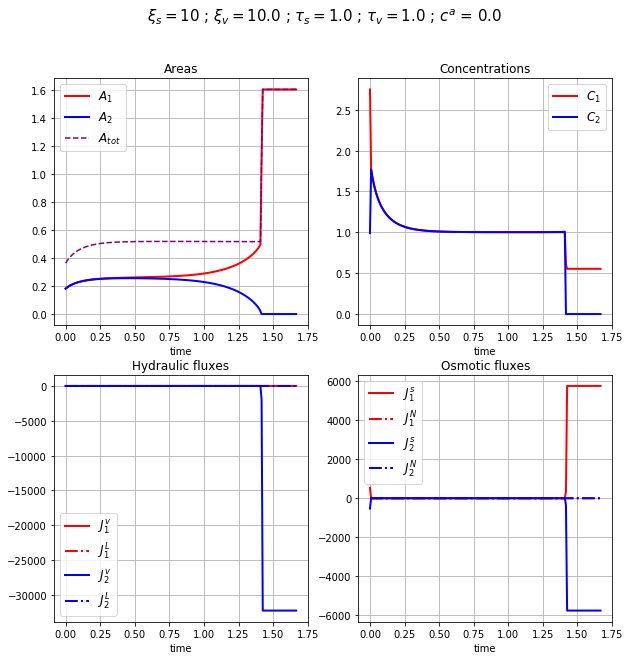

In [9]:
fig_flux, ax_flux = plt.subplots(2, 2, figsize=(10, 10))

plt.suptitle(r'$\xi_s = $'+str(xis)+r' ; $\xi_v = $'+str(xiv) + r' ; $\tau_s = $'+str(taus) + r' ; $\tau_v = $'+str(tauv) + r' ; $c^a$ = ' + str(ca), fontsize=15)

start, end = 0, -40

ax_flux[0, 0].plot(t[start:end], A1[start:end], color = 'r', linewidth=2, linestyle = '-', label=r'$A_1$')
ax_flux[0, 0].plot(t[start:end], A2[start:end], color = 'b', linewidth=2, linestyle = '-', label=r'$A_2$')
ax_flux[0, 0].plot(t[start:end], A1[start:end]+A2[start:end], color = 'purple', linestyle = '--', label=r'$A_{tot}}$')
ax_flux[0, 0].set_xlabel('time')
ax_flux[0, 0].set_title('Areas')
ax_flux[0, 0].legend(fontsize=12)
ax_flux[0, 0].grid()

ax_flux[0, 1].plot(t[start:end], dC1_out[start:end]+1., color = 'r', linewidth=2, linestyle = '-', label=r'$C_1$')
ax_flux[0, 1].plot(t[start:end], dC2_out[start:end]+1., color = 'b', linewidth=2, linestyle = '-', label=r'$C_2$')
ax_flux[0, 1].set_xlabel('time')
ax_flux[0, 1].set_title('Concentrations')
ax_flux[0, 1].legend(fontsize=12)
ax_flux[0, 1].grid()

ax_flux[1, 0].plot(t[start:end], j1v[start:end], color = 'r', linewidth=2, linestyle = '-', label=r'$J_1^v$')
ax_flux[1, 0].plot(t[start:end], jL1[start:end], color = 'r', linewidth=2, linestyle = '-.', label = r'$J_1^L$')

ax_flux[1, 0].plot(t[start:end], j2v[start:end], color = 'b', linewidth=2, linestyle = '-', label=r'$J_2^v$')
ax_flux[1, 0].plot(t[start:end], jL2[start:end], color = 'b', linewidth=2, linestyle = '-.', label = r'$J_2^L$')

ax_flux[1, 0].set_xlabel('time')
ax_flux[1, 0].set_title('Hydraulic fluxes')
ax_flux[1, 0].legend(fontsize=12)
ax_flux[1, 0].grid()

ax_flux[1, 1].plot(t[start:end], j1s[start:end], color = 'r', linewidth=2, linestyle = '-', label=r'$J_1^s$')
ax_flux[1, 1].plot(t[start:end], jN1[start:end], color = 'r', linewidth=2, linestyle = '-.', label = r'$J_1^N$')
ax_flux[1, 1].plot(t[start:end], j2s[start:end], color = 'b', linewidth=2, linestyle = '-', label=r'$J_2^s$')
ax_flux[1, 1].plot(t[start:end], jN2[start:end], color = 'b', linewidth=2, linestyle = '-.', label = r'$J_2^N$')

ax_flux[1, 1].set_xlabel('time')
ax_flux[1, 1].set_title('Osmotic fluxes')
ax_flux[1, 1].legend(fontsize=12)
ax_flux[1, 1].grid()
plt.show()

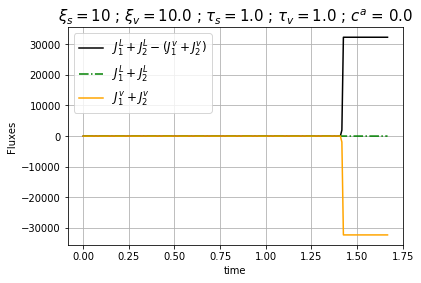

In [10]:
plt.title(r'$\xi_s = $'+str(xis)+r' ; $\xi_v = $'+str(xiv) + r' ; $\tau_s = $'+str(taus) + r' ; $\tau_v = $'+str(tauv) + r' ; $c^a$ = ' + str(ca), fontsize=15)
plt.plot(t[start:end], jL1[start:end]+jL2[start:end] - (j1v[start:end]+j2v[start:end]), color = 'k', linestyle = '-', label = r'$J_1^L+J_2^L - (J_1^v+J_2^v)$')
plt.plot(t[start:end], jL1[start:end]+jL2[start:end], color = 'green', linestyle = '-.', label = r'$J_1^L+J_2^L$')
plt.plot(t[start:end], j1v[start:end]+j2v[start:end], color = 'orange', linestyle = '-', label = r'$J_1^v+J_2^v$')
plt.legend(fontsize=12)
plt.xlabel('time')
plt.ylabel('Fluxes')
plt.grid()


In [13]:
from scipy.optimize import newton

In [63]:

def f_j1v_left(x, dC2=dC2, P1=P1, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L) :
    return system.func_J1v(dC1=x-1., dC2=dC2, P1=P1, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L)
    #return 0.1*x+1

def f_j1v_right(x, dC1=dC1, P1=P1, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L) :
    return system.func_J1v(dC1=dC1, dC2=x-1., P1=P1, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L)


NameError: name 'dC2' is not defined

In [15]:
P2 = 1.
chis, chiv = .2, .2
ca = 0.
ellt=0.5
L=1.

c = 1.

-0.47015106981204496
-0.4968354205766954
-0.5209608782792379
0.9426782064471353
0.9481876290232499
0.9527308523438897


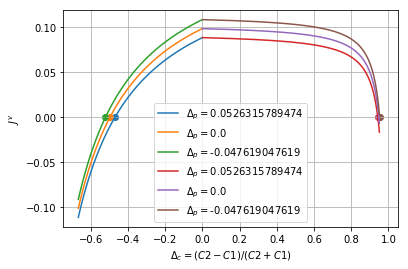

In [16]:

# Left part
C2 = c
C1 = np.linspace(1., 5., 101)
Delta_c = (C2-C1)/(C1+C2)

for p in [0.9, 1., 1.1] :
    j1v_l = f_j1v_left(C1, dC2=C2-1., P1=p, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L)
    c0 = newton(func=f_j1v_left, x0=0, args=(C2-1, p, P2, chis, chiv, ca, ellt, L))
    Delta_c0 = (C2-c0)/(c0+C2)
    print Delta_c0
    plt.plot(Delta_c, j1v_l, label=r'$\Delta_p = $'+str((P2-p)/(p+P2)))
    plt.scatter(Delta_c0, 0)
    
# Right part
C1 = c
C2 = np.linspace(1., 40., 101)
Delta_c = (C2-C1)/(C1+C2)

for p in [0.9, 1., 1.1] :
    j1v_r = f_j1v_right(C2, dC1=C1-1., P1=p, P2=P2, chis=chis, chiv=chiv, ca=ca, ellt=ellt, L=L)
    c0 = newton(func=f_j1v_right, x0=0, args=(C1-1., p, P2, chis, chiv, ca, ellt, L))
    Delta_c0 = (c0-C1)/(c0+C1)
    print Delta_c0
    plt.plot(Delta_c, j1v_r, label=r'$\Delta_p = $'+str((P2-p)/(p+P2)))
    plt.scatter(Delta_c0, 0)
    
    
    

plt.grid()
plt.xlabel(r'$\Delta_c = (C2-C1)/(C2+C1)$')
#plt.xlabel(r'$C_1$')
plt.ylabel(r'$J^v$')
plt.legend()
plt.show()

In [184]:


P1_list = np.linspace(0,2 , 101)

jv_deltaP = np.array([newton(func=f_j1v, x0=0, args=(dC2, P1_list[i], P2, chis, chiv, ca, ellt, L)) for i in range(len(P1_list))])



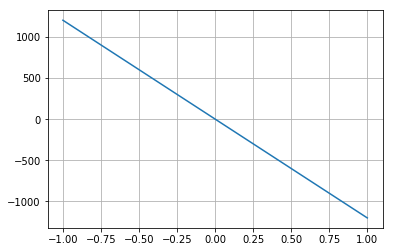

In [185]:
plt.plot(P2-P1_list, jv_deltaP)
plt.grid()